In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [2]:
data = pd.read_csv("heart.csv")
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
data.isnull().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


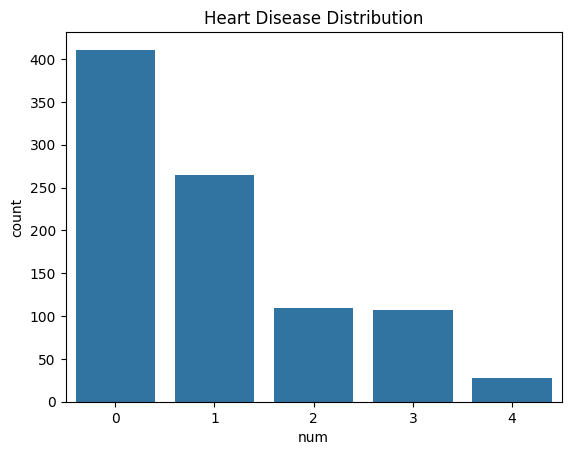

In [6]:
sns.countplot(x="num", data=data)
plt.title("Heart Disease Distribution")
plt.show()

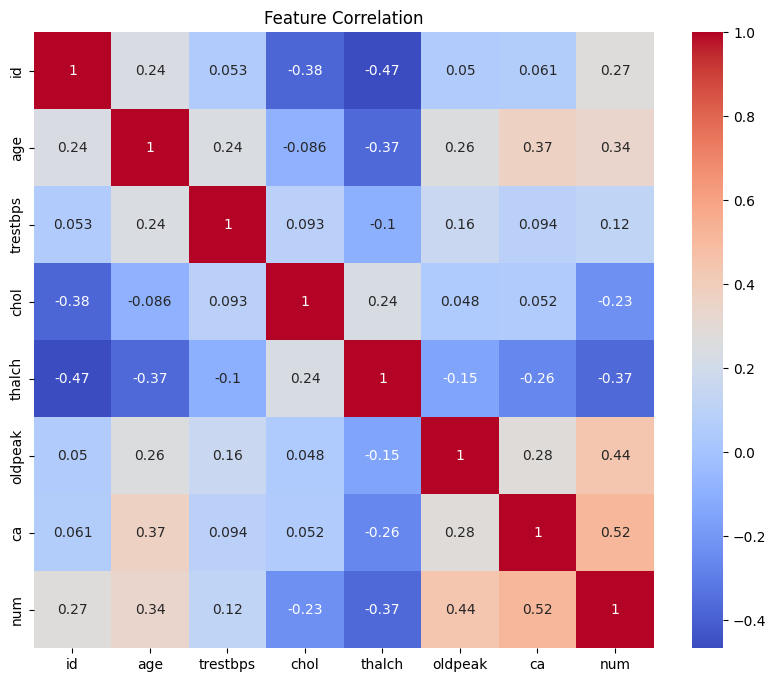

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

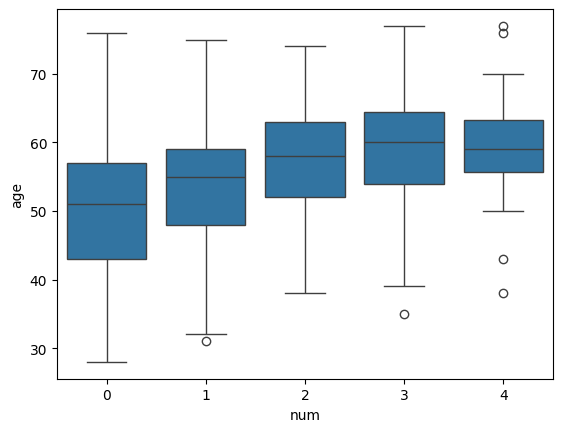

In [10]:
sns.boxplot(x="num", y="age", data=data)
plt.show()

In [12]:
X = data.drop("num", axis=1)
y = data["num"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
from sklearn.preprocessing import StandardScaler

# Preprocessing steps for X_train and X_test
# Handle missing values

# Impute numerical columns with mean
numerical_cols = X_train.select_dtypes(include=np.number).columns
for col in numerical_cols:
    if X_train[col].isnull().any():
        mean_val = X_train[col].mean()
        X_train[col] = X_train[col].fillna(mean_val)
        X_test[col] = X_test[col].fillna(mean_val)

# Impute categorical columns with mode
categorical_cols = X_train.select_dtypes(include='object').columns
for col in categorical_cols:
    if X_train[col].isnull().any():
        mode_val = X_train[col].mode()[0]
        X_train[col] = X_train[col].fillna(mode_val)
        X_test[col] = X_test[col].fillna(mode_val)

# One-hot encode categorical features
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Scale numerical columns after one-hot encoding
# Filter for columns that are present in the dataframe after get_dummies
current_numerical_cols = [col for col in numerical_cols if col in X_train.columns]
if current_numerical_cols:
    scaler = StandardScaler()
    X_train[current_numerical_cols] = scaler.fit_transform(X_train[current_numerical_cols])
    X_test[current_numerical_cols] = scaler.transform(X_test[current_numerical_cols])

# Align columns to ensure X_train and X_test have the same columns
# This is important if some categories appear in train but not test, or vice-versa
common_cols = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]

# Reorder columns to be identical
X_test = X_test[X_train.columns]

# Now fit the model
log_model = LogisticRegression(max_iter=5000) # Increased max_iter to ensure convergence
log_model.fit(X_train, y_train)

log_pred = log_model.predict(X_test)

In [15]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

tree_pred = tree_model.predict(X_test)

In [17]:
print("Logistic Regression Accuracy:",
      accuracy_score(y_test, log_pred))

print("Decision Tree Accuracy:",
      accuracy_score(y_test, tree_pred))

Logistic Regression Accuracy: 0.5489130434782609
Decision Tree Accuracy: 0.5543478260869565


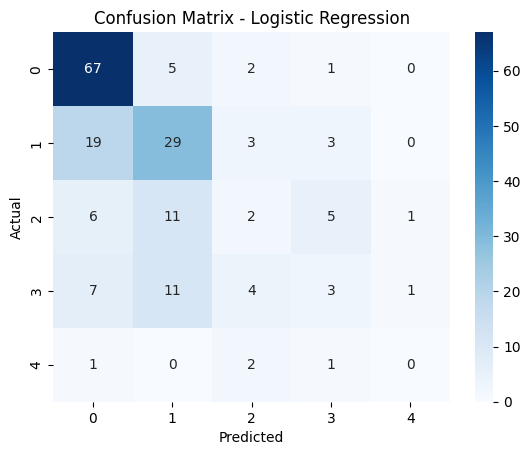

In [18]:
cm = confusion_matrix(y_test, log_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

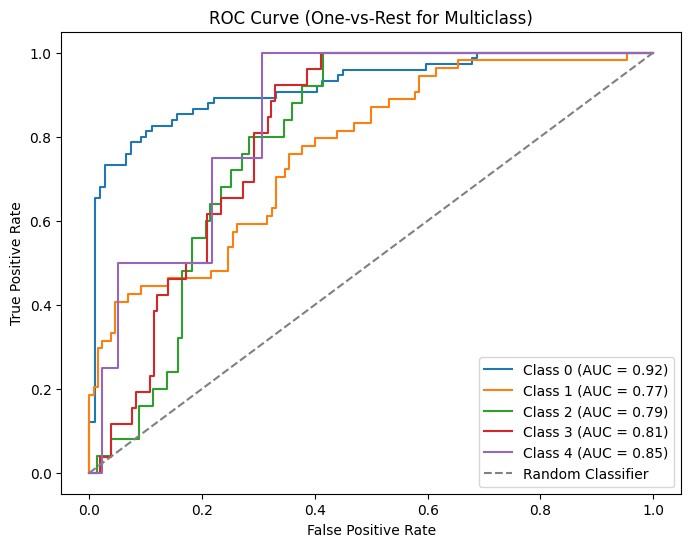

In [22]:
log_probs = log_model.predict_proba(X_test)
num_classes = len(log_model.classes_)

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    # For each class, plot ROC curve
    # y_true needs to be binary: 1 if it's the current class, 0 otherwise
    # y_score needs to be the probability of belonging to the current class
    binary_y_test = (y_test == log_model.classes_[i]).astype(int)
    fpr, tpr, _ = roc_curve(binary_y_test, log_probs[:, i])
    auc_score = roc_auc_score(binary_y_test, log_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {log_model.classes_[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color='grey', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest for Multiclass)")
plt.legend()
plt.show()

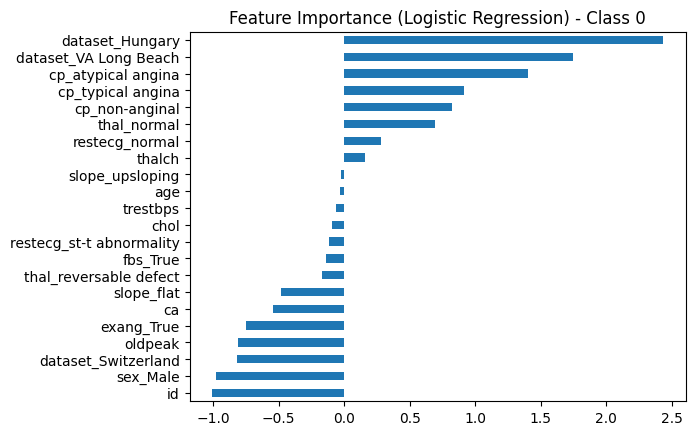

In [24]:
importance = pd.Series(log_model.coef_[0], index=X_train.columns)
importance.sort_values().plot(kind='barh')
plt.title("Feature Importance (Logistic Regression) - Class 0")
plt.show()

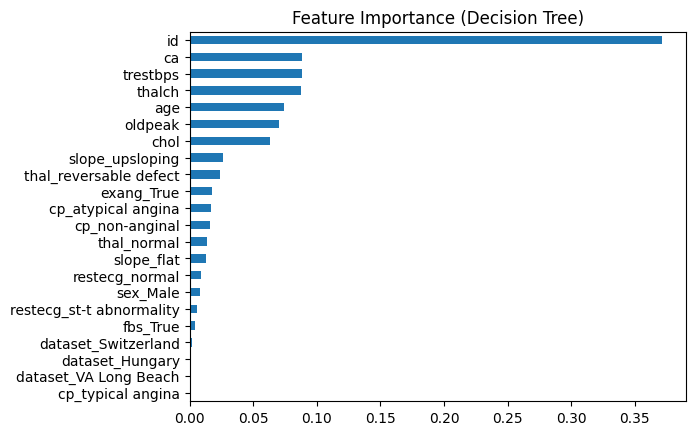

In [26]:
importance_tree = pd.Series(tree_model.feature_importances_, index=X_train.columns)
importance_tree.sort_values().plot(kind='barh')
plt.title("Feature Importance (Decision Tree)")
plt.show()